In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# Helpful statement for debugging, prints the thing entered as x and the output, i.e.,
# debugPrint(1+1) will output '1+1 [int] = 2'
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
    
    
import os
import os, sys
# sys.path.append(os.path.join('~/dev/pytorchSPH/', "lib"))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm.notebook import trange, tqdm
import yaml
%matplotlib widget
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch
from torch_geometric.nn import radius
from torch_geometric.nn import SplineConv, fps, global_mean_pool, radius_graph, radius
from torch_scatter import scatter

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

import torch
# import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from tqdm import TqdmExperimentalWarning

warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)

import seaborn as sns
from diffSPH.util import evalArea
from diffSPH.noise.generator import generatePerlin, generateSimplex, generateOctaveNoise
from scipy import interpolate
from diffSPH.modules.neighborSearch import radiusCompactHashMap, periodicNeighborSearch
from diffSPH.util import scatter_sum
from diffSPH.kernels import *
from diffSPH.randomParticles import generatePeriodicRandomParticles

Cuda compiler: /home/winchenbach/anaconda3/envs/torch_22


KeyboardInterrupt: 

In [2]:
def plotKernel(fig, axis, xx, nx, dx, Kernel, i, label):
    rx = torch.linalg.norm(xx, dim = -1) / h
    nx = xx / (torch.linalg.norm(xx, dim = -1).view(-1,1) + 1e-7 * 1)
    c = torch.tensor([0,0,0], dtype = float)
    c[0] = c[0] + dx
    rhx = torch.linalg.norm(xx - c, dim = -1) / h
    nhx = (xx - c) / (torch.linalg.norm((xx - c), dim = -1) +1e-7 * h).view(-1,1)

    
    fx = Kernel.kernel(rx, torch.ones_like(rx) * h, dim)
    dfx = Kernel.kernelGradient(rx, nx, torch.ones_like(rx) * h, dim)
    ndfx = (Kernel.kernel(rhx, torch.ones_like(rx) * h, dim) - Kernel.kernel(rx, torch.ones_like(rx) * h, dim)) / dx
    nd2fxa = (Kernel.kernelGradient(rhx, nx , torch.ones_like(rx)* h, dim)[:,0] - Kernel.kernelGradient(rx, nx, torch.ones_like(rx) * h, dim)[:,0])
    nd2fxb = (Kernel.kernelGradient(rx, nhx , torch.ones_like(rx)* h, dim)[:,0] - Kernel.kernelGradient(rx, nx, torch.ones_like(rx) * h, dim)[:,0])
    
    rpx  = torch.linalg.norm(xx - torch.tensor([1 * dx,0,0], dtype = float), dim = -1) / h
    rp2x = torch.linalg.norm(xx - torch.tensor([2 * dx,0,0], dtype = float), dim = -1) / h
    fx = Kernel.kernel(rx, torch.ones_like(rpx) * h, dim)
    fpx = Kernel.kernel(rpx, torch.ones_like(rpx) * h, dim)
    f2px = Kernel.kernel(rp2x, torch.ones_like(rpx) * h, dim)    
    d2fxx = (fx  -2 * fpx + f2px) / dx**2
    laplacian = d2fxx
    # axis[0,2].plot(rx,d2fxx, ls = ':', c = 'blue', alpha = 0.5)
    if dim > 1:
        rpx  = torch.linalg.norm(xx - torch.tensor([0,1 * dx,0], dtype = float), dim = -1) / h
        rp2x = torch.linalg.norm(xx - torch.tensor([0,2 * dx,0], dtype = float), dim = -1) / h
        fx = Kernel.kernel(rx, torch.ones_like(rpx) * h, dim)
        fpx = Kernel.kernel(rpx, torch.ones_like(rpx) * h, dim)
        f2px = Kernel.kernel(rp2x, torch.ones_like(rpx) * h, dim)  
        d2fyy = (fx  -2 * fpx + f2px) / dx**2
        # axis[0,2].plot(rx,d2fyy, ls = '--', c = 'green', alpha = 0.5)
        laplacian = d2fxx + d2fyy
    if dim > 2:
        rpx  = torch.linalg.norm(xx - torch.tensor([0,0,1 * dx], dtype = float), dim = -1) / h
        rp2x = torch.linalg.norm(xx - torch.tensor([0,0,2 * dx], dtype = float), dim = -1) / h
        fx = Kernel.kernel(rx, torch.ones_like(rpx) * h, dim)
        fpx = Kernel.kernel(rpx, torch.ones_like(rpx) * h, dim)
        f2px = Kernel.kernel(rp2x, torch.ones_like(rpx) * h, dim)    
        d2fzz = (fx  -2 * fpx + f2px) / dx**2
        laplacian = d2fxx + d2fyy + d2fzz

    axis[0,0].plot(rx,fx, c = colors[i], label = label)
    axis[0,1].plot(rx,dfx[:,0], ls = '-', c = colors[i], label = label)
    axis[0,1].plot(rx,-ndfx, ls = ':', c = 'black', alpha = 0.5)
    if hasattr(Kernel, 'kernelLaplacian'):
        lap = Kernel.kernelLaplacian(rx, torch.ones_like(rx) * h,dim)
        axis[0,2].plot(rx, lap, c = colors[i], label = label)
        # print('Laplacian of ', label, lap)
    axis[0,2].plot(rx,laplacian, ls = ':', c = 'black', alpha = 0.5)
    
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

dim = 3

h = 2
n = 2**10
xx = torch.linspace(0,h,n).view(-1,1)
if dim > 1:
    xx = torch.hstack((xx, torch.zeros(n,1)))
if dim > 2:
    xx = torch.hstack((xx, torch.zeros(n,1)))

nx = xx / (torch.linalg.norm(xx, dim = -1).view(-1,1) + 1e-7 * h)
rx = torch.linalg.norm(xx, dim = -1)
# nx = xx / (torch.linalg.norm(xx, dim = -1).view(-1,1) + 1e-7 * h)
dx = 1e-2

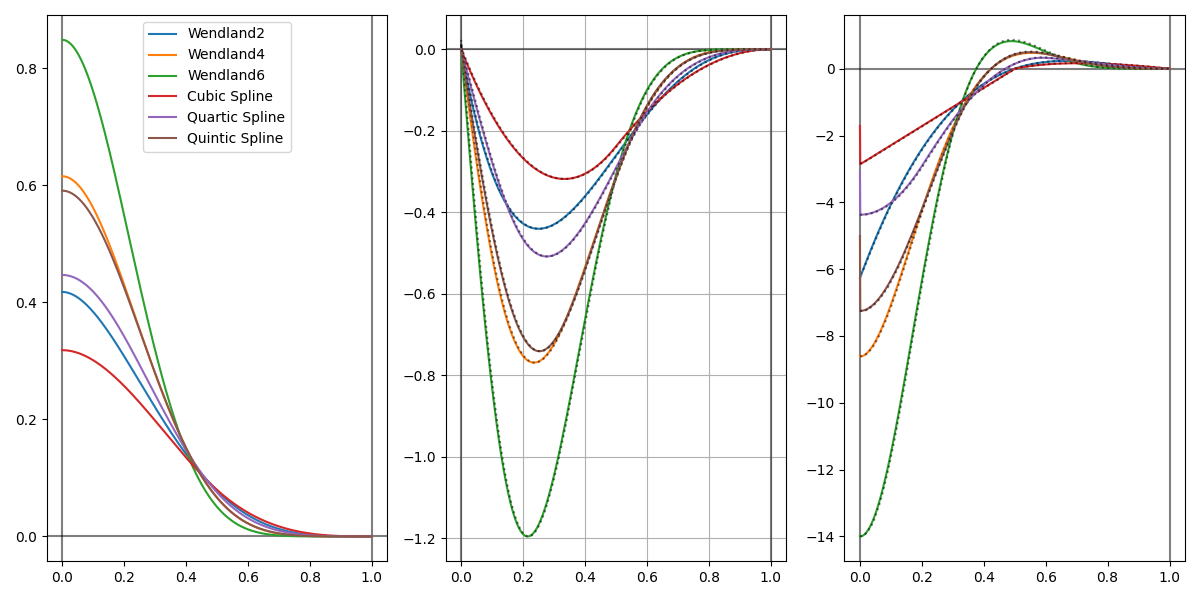

In [3]:
fig, axis = plt.subplots(1, 3, figsize=(12,6), sharex = False, sharey = False, squeeze = False)


axis[0,0].axvline(0, ls = '-', c = 'black', alpha = 0.5)
axis[0,0].axvline(1, ls = '-', c = 'black', alpha = 0.5)
axis[0,0].axhline(0, ls = '-', c = 'black', alpha = 0.5)
axis[0,1].axvline(0, ls = '-', c = 'black', alpha = 0.5)
axis[0,1].axvline(1, ls = '-', c = 'black', alpha = 0.5)
axis[0,1].axhline(0, ls = '-', c = 'black', alpha = 0.5)
axis[0,2].axvline(0, ls = '-', c = 'black', alpha = 0.5)
axis[0,2].axvline(1, ls = '-', c = 'black', alpha = 0.5)
axis[0,2].axhline(0, ls = '-', c = 'black', alpha = 0.5)

plotKernel(fig, axis, xx, nx, dx, getKernel('Wendland2'), 0, 'Wendland2')
plotKernel(fig, axis, xx, nx, dx, getKernel('Wendland4'), 1, 'Wendland4')
plotKernel(fig, axis, xx, nx, dx, getKernel('Wendland6'), 2, 'Wendland6')
plotKernel(fig, axis, xx, nx, dx, getKernel('CubicSpline'), 3, 'Cubic Spline')
plotKernel(fig, axis, xx, nx, dx, getKernel('QuarticSpline'), 4, 'Quartic Spline')
plotKernel(fig, axis, xx, nx, dx, getKernel('QuinticSpline'), 5, 'Quintic Spline')

axis[0,0].grid(which = 'both')
axis[0,1].grid(which = 'both')
axis[0,0].grid(which = 'both')

axis[0,0].legend()
fig.tight_layout()

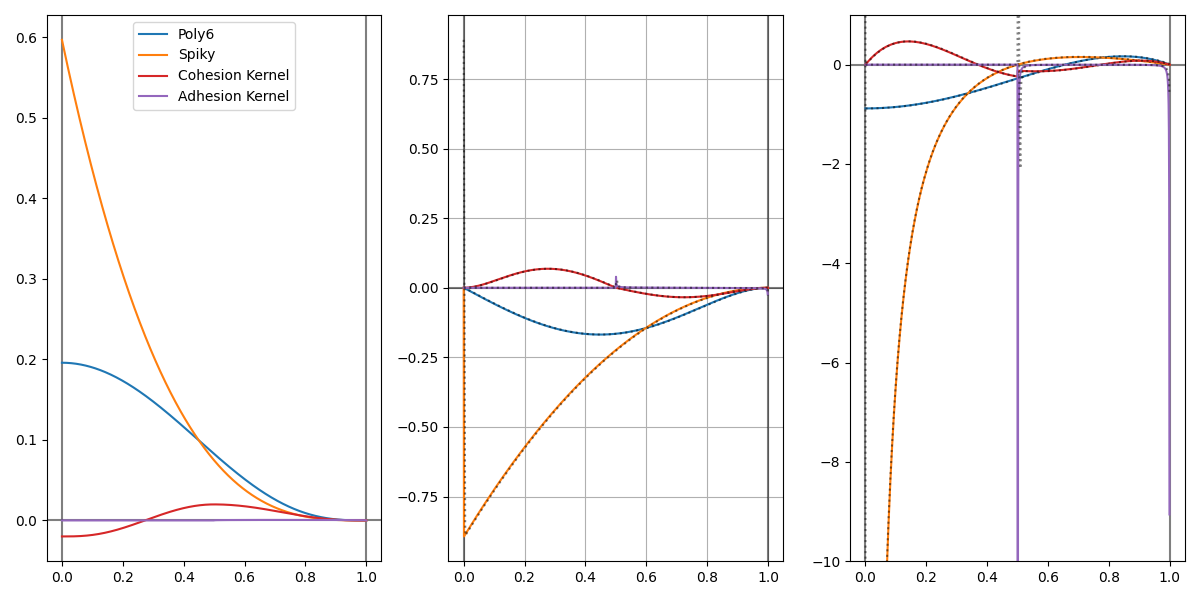

In [4]:
fig, axis = plt.subplots(1, 3, figsize=(12,6), sharex = False, sharey = False, squeeze = False)


axis[0,0].axvline(0, ls = '-', c = 'black', alpha = 0.5)
axis[0,0].axvline(1, ls = '-', c = 'black', alpha = 0.5)
axis[0,0].axhline(0, ls = '-', c = 'black', alpha = 0.5)
axis[0,1].axvline(0, ls = '-', c = 'black', alpha = 0.5)
axis[0,1].axvline(1, ls = '-', c = 'black', alpha = 0.5)
axis[0,1].axhline(0, ls = '-', c = 'black', alpha = 0.5)
axis[0,2].axvline(0, ls = '-', c = 'black', alpha = 0.5)
axis[0,2].axvline(1, ls = '-', c = 'black', alpha = 0.5)
axis[0,2].axhline(0, ls = '-', c = 'black', alpha = 0.5)

plotKernel(fig, axis, xx, nx, dx, getKernel('Poly6'), 0, 'Poly6')
plotKernel(fig, axis, xx, nx, dx, getKernel('Spiky'), 1, 'Spiky')
# plotKernel(fig, axis, xx, nx, dx, getKernel('ViscosityKernel'), 2, 'Viscosity Kernel')
plotKernel(fig, axis, xx, nx, dx, getKernel('CohesionKernel'), 3, 'Cohesion Kernel')
plotKernel(fig, axis, xx, nx, dx, getKernel('AdhesionKernel'), 4, 'Adhesion Kernel')

axis[0,0].grid(which = 'both')
axis[0,1].grid(which = 'both')
axis[0,0].grid(which = 'both')

axis[0,2].set_ylim(-10,1)

axis[0,0].legend()
fig.tight_layout()

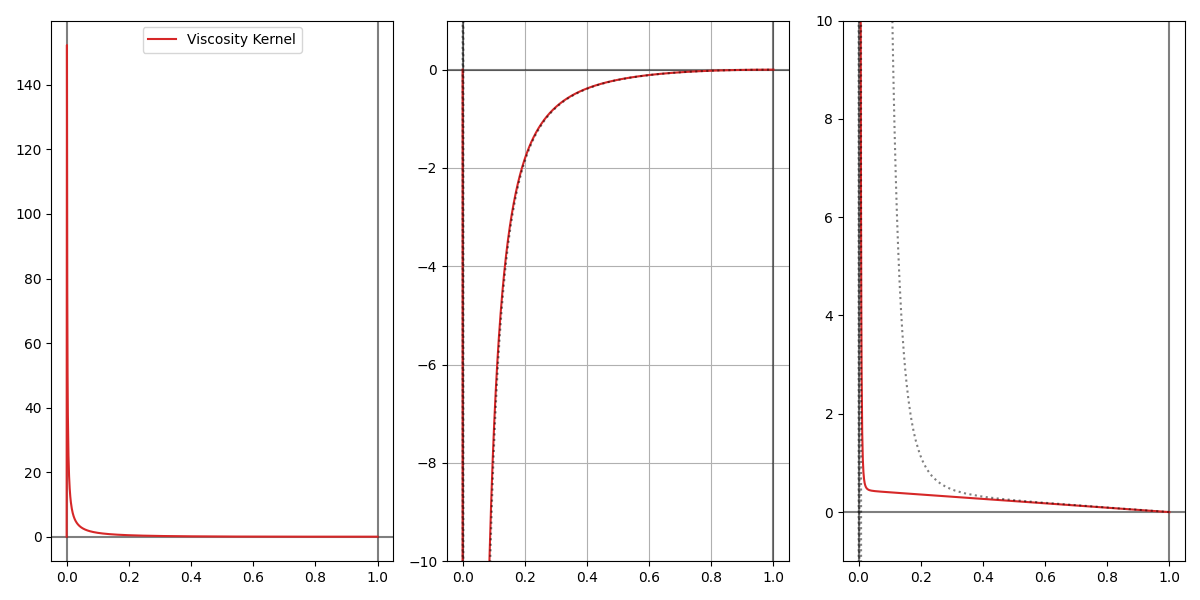

In [6]:
fig, axis = plt.subplots(1, 3, figsize=(12,6), sharex = False, sharey = False, squeeze = False)


axis[0,0].axvline(0, ls = '-', c = 'black', alpha = 0.5)
axis[0,0].axvline(1, ls = '-', c = 'black', alpha = 0.5)
axis[0,0].axhline(0, ls = '-', c = 'black', alpha = 0.5)
axis[0,1].axvline(0, ls = '-', c = 'black', alpha = 0.5)
axis[0,1].axvline(1, ls = '-', c = 'black', alpha = 0.5)
axis[0,1].axhline(0, ls = '-', c = 'black', alpha = 0.5)
axis[0,2].axvline(0, ls = '-', c = 'black', alpha = 0.5)
axis[0,2].axvline(1, ls = '-', c = 'black', alpha = 0.5)
axis[0,2].axhline(0, ls = '-', c = 'black', alpha = 0.5)

plotKernel(fig, axis, xx, nx, dx, getKernel('ViscosityKernel'), 3, 'Viscosity Kernel')
axis[0,2].set_ylim(-1,10)
axis[0,1].set_ylim(-10,1)

axis[0,0].grid(which = 'both')
axis[0,1].grid(which = 'both')
axis[0,0].grid(which = 'both')

axis[0,0].legend()
fig.tight_layout()